# Import Libraries

In [1]:
# Basic Libraries 
# --------------------------------------
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from pylab import rcParams
import sys

# import matplotlib
#  matplotlib.use("Qt5Agg")
import missingno as msno
from datetime import date
import joblib
import logging
import yellowbrick
from yellowbrick.model_selection import FeatureImportances
import pickle
import optuna
import scipy
import statsmodels.api as sm

# Plotly Express - Plotly - cufflinks 
# --------------------------------------

import cufflinks as cf
import plotly.express as px
import plotly.offline as py
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot
import plotly.figure_factory as ff

init_notebook_mode(connected=True)

# Metrics 
# --------------------------------------
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, StratifiedKFold, RepeatedKFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, \
    classification_report, mean_squared_error, mean_absolute_error, r2_score, precision_recall_curve, auc, average_precision_score, roc_curve
from sklearn.neighbors import LocalOutlierFactor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer, KNNImputer
import optuna
import optuna.logging as optuna_logging

# Machine Learning Models For Regression 
# --------------------------------------
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor


# Machine Learning Models For Classification 
# --------------------------------------
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB, CategoricalNB, ComplementNB


# Remove Warnings
# ------------------------------------------------------------
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 600)
from termcolor import colored

constraints = ['#581845', '#C70039']
metric_constraints = ['#2ECC71', '#34495E', '#D0D3D4']
cat_feat_constraints = ['#7FB3D5', '#76D7C4', '#F7DC6F', '#85929E', '#283747']


# Load And Check Data

In [2]:
df = pd.read_csv("datasets/diabetes.csv")

# Exploratory Data Analysis

In [14]:
def missing_values_analysis(df):
    na_columns_ = [col for col in df.columns if df[col].isnull().sum() > 0]
    n_miss = df[na_columns_].isnull().sum().sort_values(ascending=False)
    ratio_ = (df[na_columns_].isnull().sum() / df.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio_, 2)], axis=1, keys=['Total Missing Values', 'Ratio'])
    missing_df = pd.DataFrame(missing_df).sort_values(by="Ratio", ascending=False)
    return missing_df


def check_df(df, head=5):
    print("Info".center(100, '~'))
    print(df.info())
    print(" Dataframe - Head ".center(100, '~'))
    print(df.head(head))
    print("Unique Values".center(100, '~'))
    print(df.nunique())
    print(" Missing Values Analysis ".center(100, '~'))
    print(missing_values_analysis(df))
    print(' Duplicate Values Analysis '.center(100, '~'))
    print(df.duplicated().sum())

    try:
        print(" Describe Numeric ".center(100, '~'))
        print(df.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)
    except:
        print("There is no numeric variable in the dataset")
    
    try:
        print(" Describe Object ".center(100, '~'))
        print(df.describe(include=['category']))
    except:
        print("There is no categorical variable in the dataset")


check_df(df)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~Info~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Dataframe - Head ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
   Pregnancies  Glucose  BloodPre

In [4]:
# shuffle_indices = np.random.permutation(len(df))
# df = df.iloc[shuffle_indices]

In [5]:
def grab_col_names(df, cat_th=10, car_th=20):
    cat_cols = [col for col in df.columns if df[col].dtypes == "O"]
    num_but_cat = [col for col in df.columns if df[col].dtypes != "O" and df[col].nunique() < cat_th]
    cat_but_car = [col for col in df.columns if df[col].dtypes == "O" and df[col].nunique() > car_th]

    cat_cols += num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols = [col for col in df.columns if df[col].dtypes != "O"]
    num_cols = [col for col in df.columns if df[col].dtypes in ["int", "float", "int32", "float32", "int64",
                                                                "float64"]]
    num_cols = [col for col in num_cols if col not in num_but_cat]
    print(f"Observations: {df.shape[0]} \t Variables: {df.shape[1]}")
    print("~" * 100)
    print(f'cat_cols size: {len(cat_cols)}')
    print("cat_cols:", cat_cols)
    print("~" * 100)
    print(f'num_cols size: {len(num_cols)}')
    print("num_cols:", num_cols)
    print("~" * 100)
    print(f'cat_but_car size: {len(cat_but_car)}')
    print("cat_but_car:", cat_but_car)
    print("~" * 100)
    print(f'num_but_cat size: {len(num_but_cat)}')
    print("num_but_cat:", num_but_cat)
    return cat_cols, num_cols, cat_but_car


cat_cols, num_cols, cat_but_car = grab_col_names(df)


Observations: 768 	 Variables: 9
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
cat_cols size: 1
cat_cols: ['Outcome']
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
num_cols size: 8
num_cols: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
cat_but_car size: 0
cat_but_car: []
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
num_but_cat size: 1
num_but_cat: ['Outcome']


# Analysis of Numerical Features

<Axes: xlabel='Age', ylabel='count'>

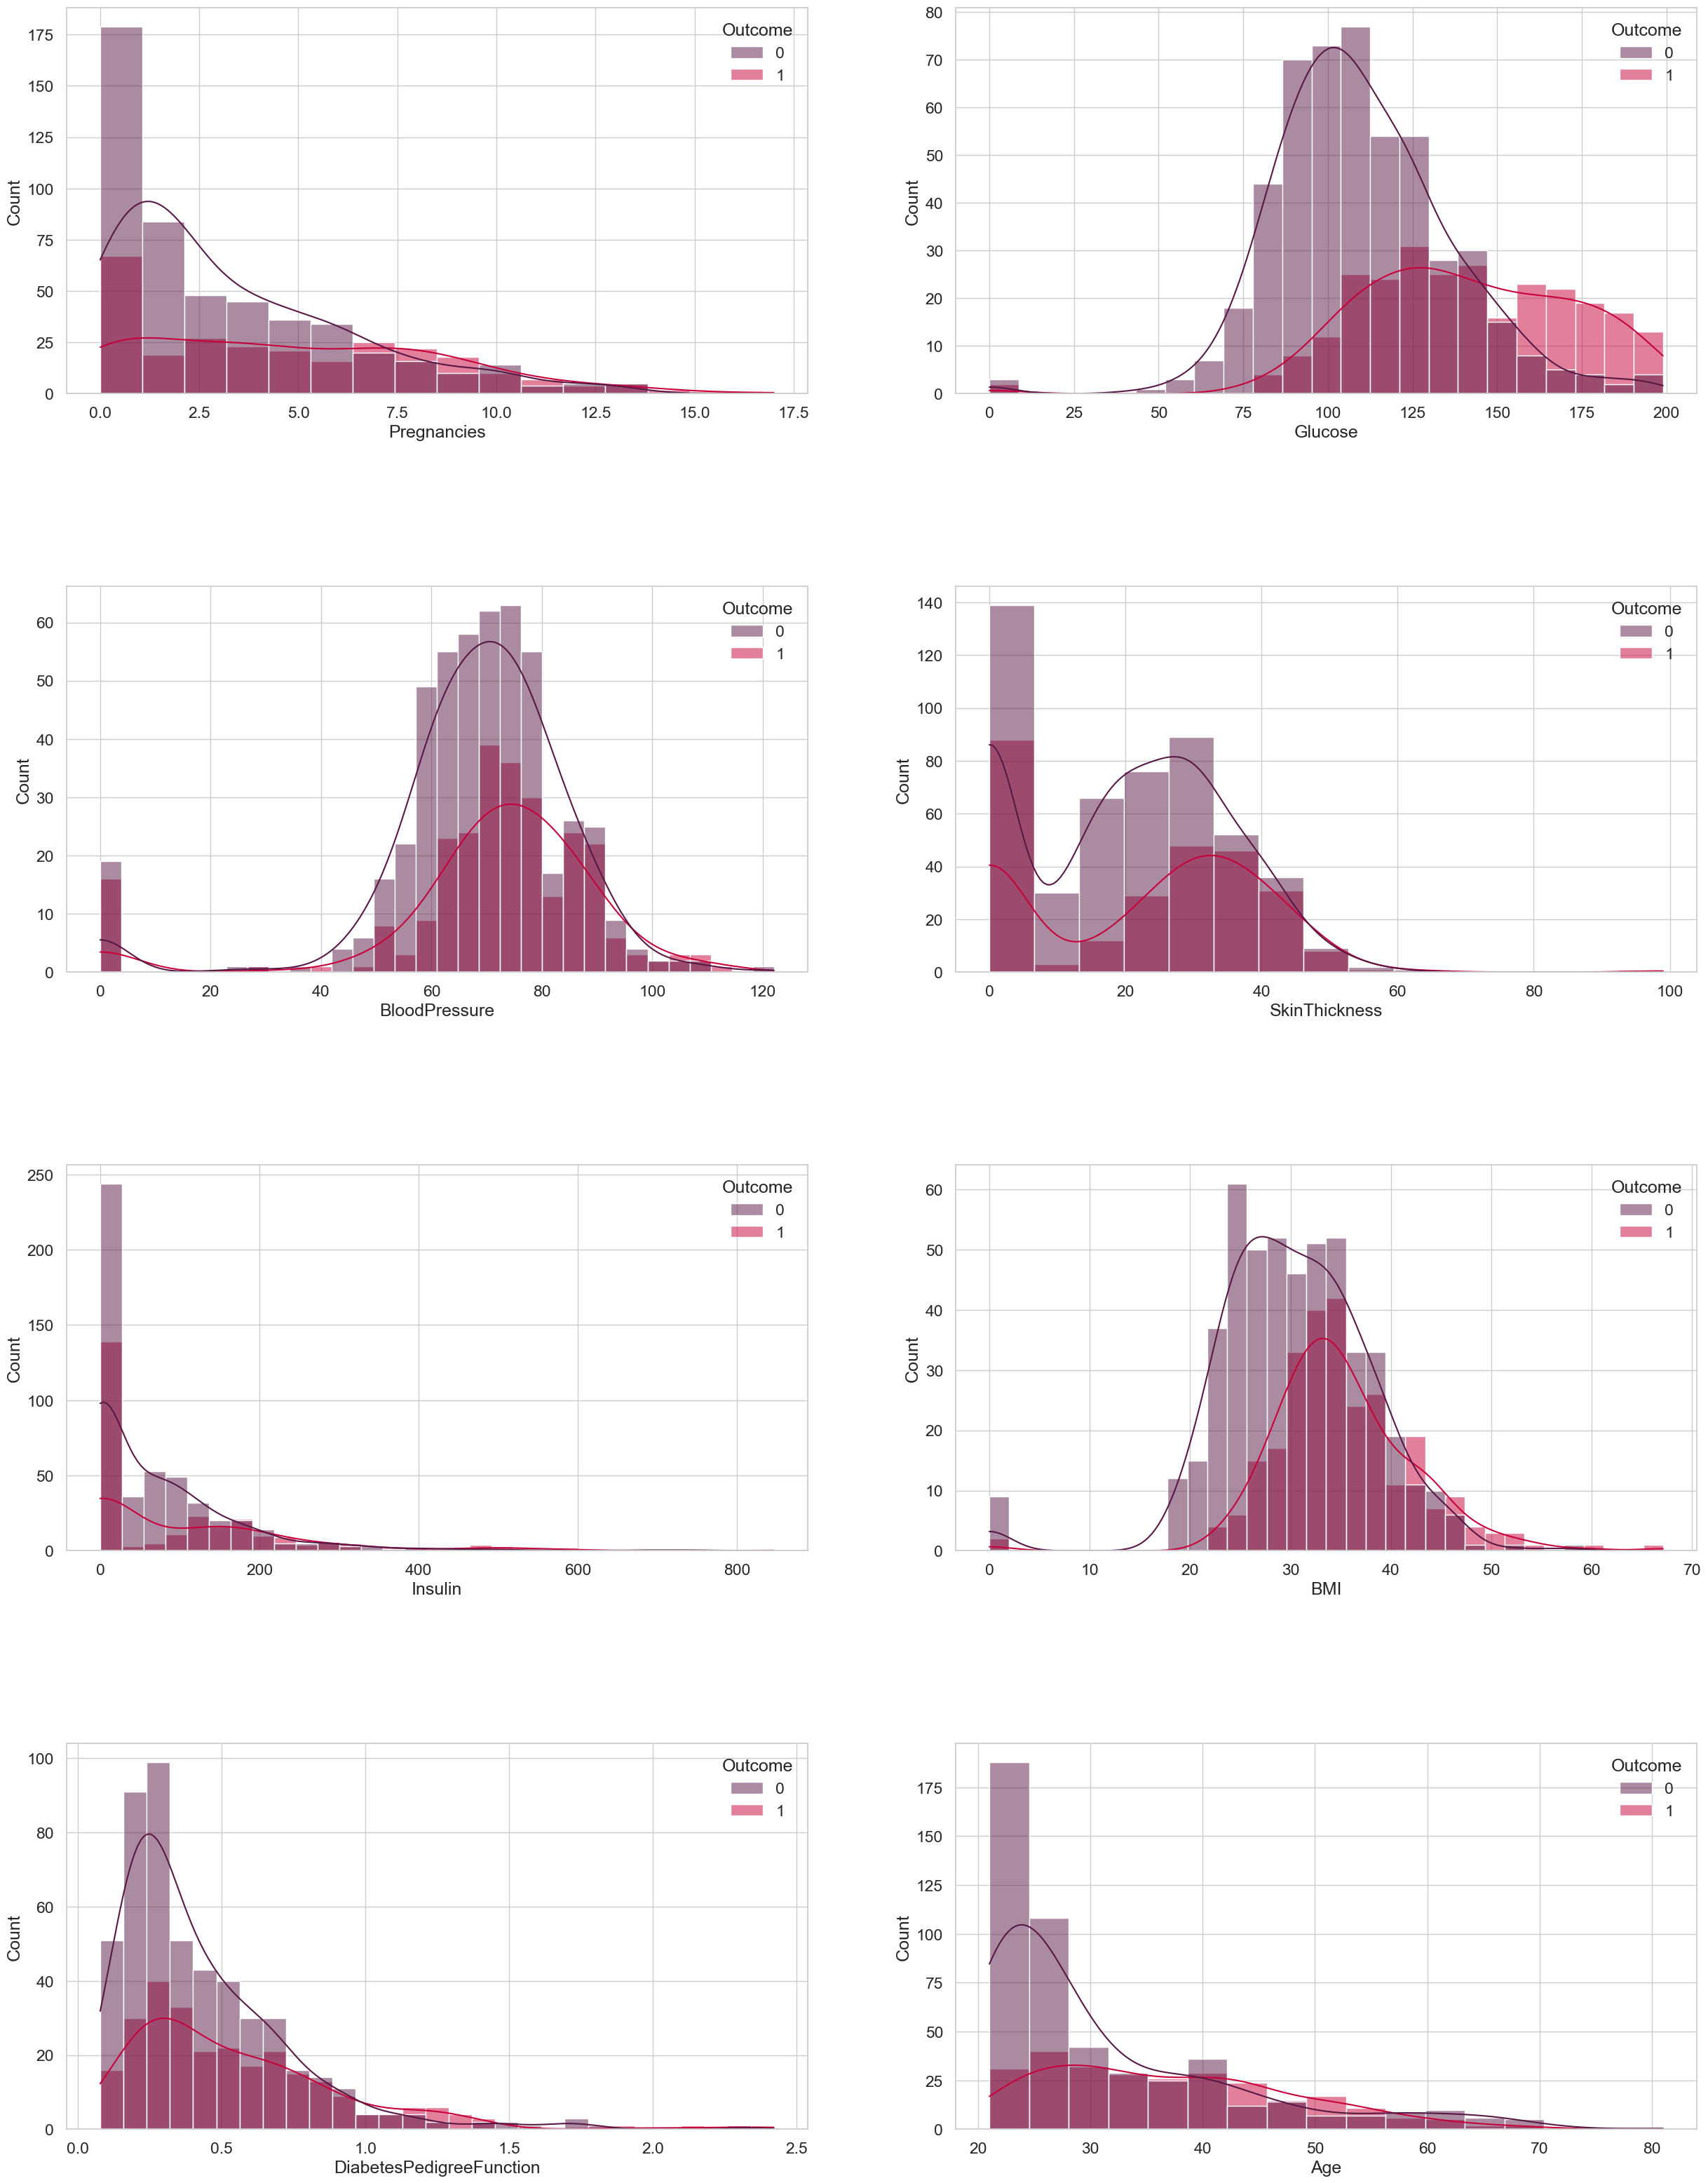

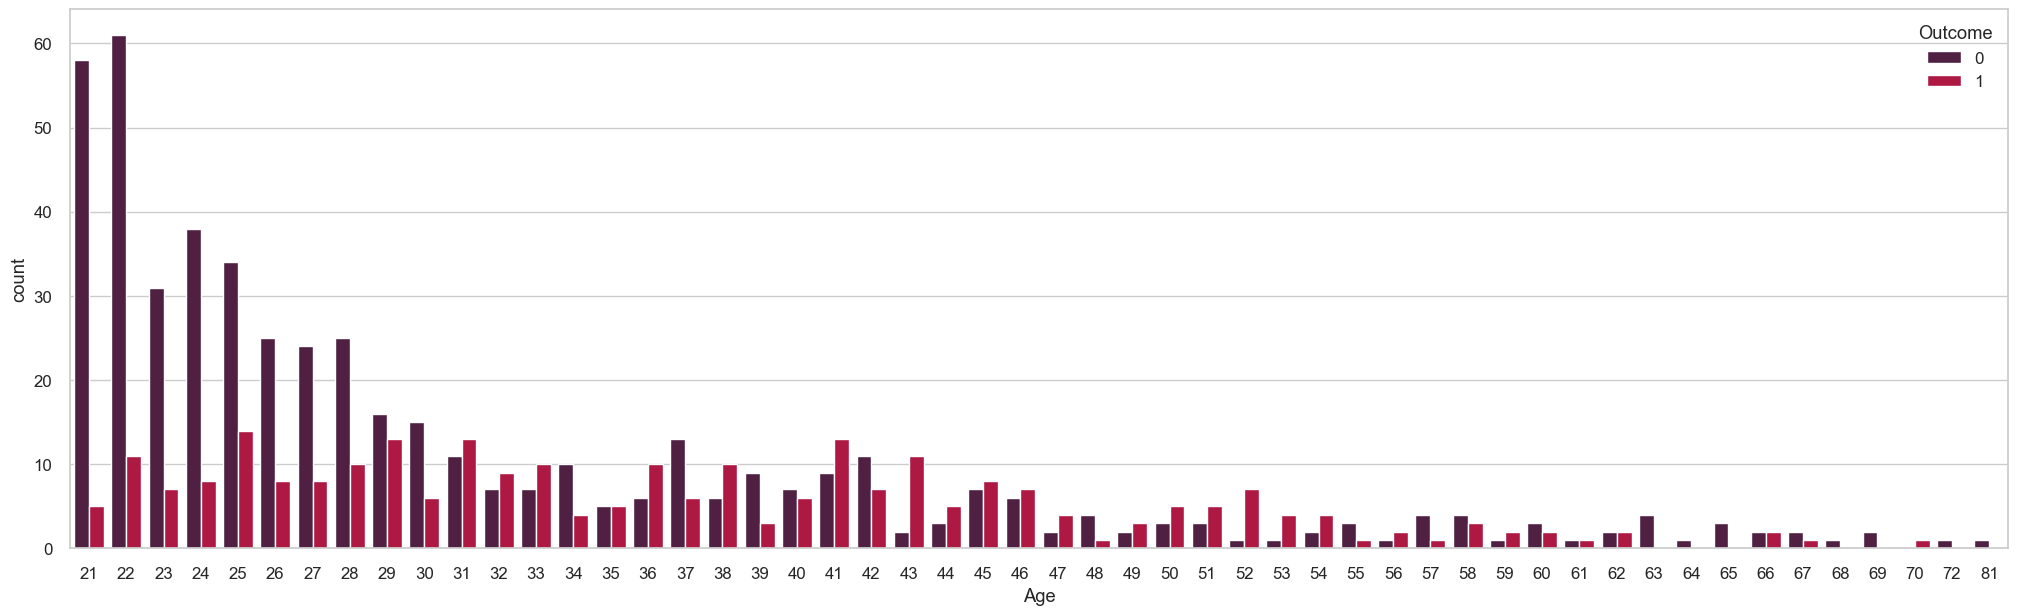

In [6]:
# def num_summary(df, numerical_col, plot=False):
#     quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
#     print(df[numerical_col].describe(quantiles))
#
#     if plot:
#         plt.figure(figsize=(10, 5))
#         # df[numerical_col].hist(bins=20)
#         sns.histplot(df[numerical_col], kde=True)
#         plt.show()
#
#
# for col in num_cols:
#     num_summary(df, col, plot=True)


def num_features_hist(df, column_name, i, hue):
    rcParams['figure.figsize'] = 30, 50
    sns.set(font_scale=1.5)
    sns.set_style("whitegrid")
    sns.set_palette("bright")
    plt.subplots_adjust(hspace=0.5)
    plt.subplot((len(num_cols) // 2 + 1), 2, i)
    sns.histplot(data=df, x=column_name, hue=hue,
                 kde=True, palette=constraints)


def num_summary(df, column_name):
    fig = make_subplots(rows=1, cols=2,
                        subplot_titles=('Quantiles', 'Distribution'))

    fig.add_trace(go.Box(y=df[column_name],
                         name=str(column_name),
                         showlegend=False,
                         boxpoints="outliers",
                         marker_color=constraints[1]),
                  row=1, col=1)

    fig.add_trace(go.Histogram(x=df[column_name],
                               xbins=dict(start=df[column_name].min(),
                                          end=df[column_name].max()),
                               showlegend=False,
                               name=str(column_name),
                               marker=dict(color=constraints[0],
                                           line=dict(color='#DBE6EC',
                                                     width=1))),
                  row=1, col=2)

    fig.update_layout(title={'text': column_name,
                             'y': 0.9,
                             'x': 0.5,
                             'xanchor': 'center',
                             'yanchor': 'top'},
                      template='plotly_white')

    iplot(fig)


i = 0
for column_name in num_cols:
    i = i + 1
    num_summary(df, column_name)
    num_features_hist(df, column_name, i, hue='Outcome')

plt.figure(figsize=(25, 7))
sns.set(font_scale=1.1)
sns.set_style("whitegrid")
plt.subplots_adjust(wspace=0.5)
sns.countplot(x=df['Age'], hue=df['Outcome'], palette=constraints)

# Analysis of Categorical Features

In [7]:
# def cat_summary(df, col_name, plot=False):
#     print(pd.DataFrame({col_name: df[col_name].value_counts(),
#                         "Ratio": 100 * df[col_name].value_counts() / len(df)}))
#     print("##########################################")
#     if plot:
#         sns.countplot(x=df[col_name], data=df)
#         plt.show()
# 
# 
# for col in cat_cols:
#     cat_summary(df, col, plot=True)


def categorical_variable_summary(df, column_name):
    fig = make_subplots(rows=1, cols=2,
                        subplot_titles=('Countplot', 'Percentages'),
                        specs=[[{"type": "xy"}, {'type': 'domain'}]])

    fig.add_trace(go.Bar(y=df[column_name].value_counts().values.tolist(),
                         x=[str(i) for i in df[column_name].value_counts().index],
                         text=df[column_name].value_counts().values.tolist(),
                         textfont=dict(size=15),
                         name=column_name,
                         textposition='auto',
                         showlegend=False,
                         marker=dict(color=cat_feat_constraints,
                                     line=dict(color='#DBE6EC',
                                               width=1))),
                  row=1, col=1)

    fig.add_trace(go.Pie(labels=df[column_name].value_counts().keys(),
                         values=df[column_name].value_counts().values,
                         textfont=dict(size=20),
                         textposition='auto',
                         showlegend=False,
                         name=column_name,
                         marker=dict(colors=cat_feat_constraints)),
                  row=1, col=2)

    fig.update_layout(title={'text': column_name,
                             'y': 0.9,
                             'x': 0.5,
                             'xanchor': 'center',
                             'yanchor': 'top'},
                      template='plotly_white')

    iplot(fig)


for cat in cat_cols:
    categorical_variable_summary(df, cat)


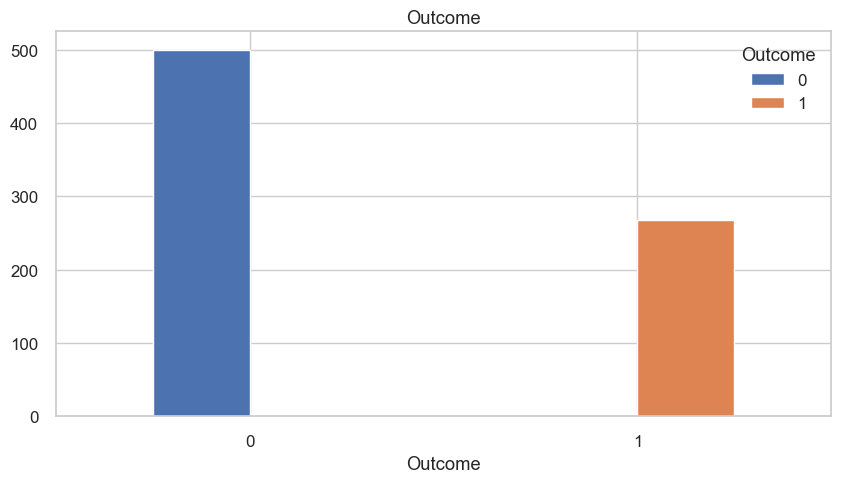

In [8]:
# Outcome değişkenine bağlı olarak kategorik değişken görselleştirme
for col in cat_cols:
    graph = pd.crosstab(index=df['Outcome'], columns=df[col]).plot.bar(figsize=(10, 5), rot=0)
    plt.title(col)
    plt.show()

# Target Variable Analysis

In [9]:
# Hedef değişken analizi

# Kategorik değişkenlerin target değişkene göre analizi
def target_summary_with_cat(df, target, categorical_col):
    print(pd.DataFrame({"Target_Mean": df.groupby(categorical_col)[target].mean(),
                        "Count": df[categorical_col].value_counts(),
                        "Ratio": 100 * df[categorical_col].value_counts() / len(df)}))
    print("#" * 50)


for col in cat_cols:
    target_summary_with_cat(df, "Outcome", col)

         Target_Mean  Count    Ratio
Outcome                             
0            0.00000    500 65.10417
1            1.00000    268 34.89583
##################################################


In [10]:
# Numerik değişkenlerin target değişkenine göre analizi

def target_summary_with_num(df, target, numerical_col):
    print(df.groupby(target).agg({numerical_col: "mean"}))
    print("#" * 50)


for col in num_cols:
    target_summary_with_num(df, "Outcome", col)

         Pregnancies
Outcome             
0            3.29800
1            4.86567
##################################################
          Glucose
Outcome          
0       109.98000
1       141.25746
##################################################
         BloodPressure
Outcome               
0             68.18400
1             70.82463
##################################################
         SkinThickness
Outcome               
0             19.66400
1             22.16418
##################################################
          Insulin
Outcome          
0        68.79200
1       100.33582
##################################################
             BMI
Outcome         
0       30.30420
1       35.14254
##################################################
         DiabetesPedigreeFunction
Outcome                          
0                         0.42973
1                         0.55050
##################################################
             Age
Outcome   

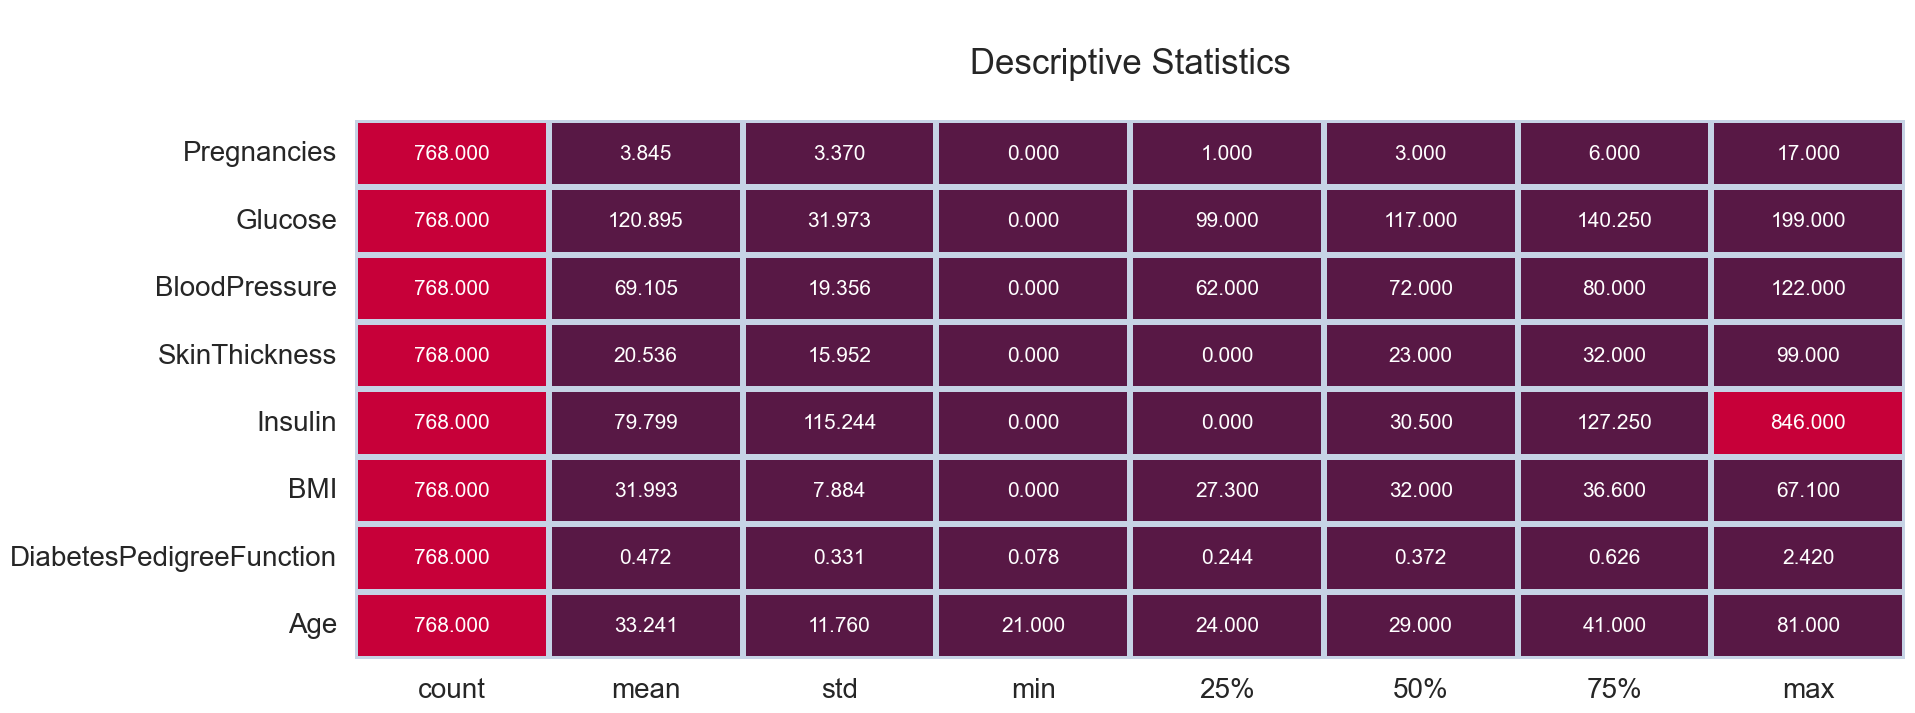

In [11]:
def descriptive_statistics(df):
    describe_ = df.describe().T
    describe_df = pd.DataFrame(index=df.columns,
                               columns=describe_.columns,
                               data=describe_)

    f, ax = plt.subplots(figsize=(20, 7))
    sns.heatmap(describe_df,
                annot=True,
                cmap=constraints,
                fmt='.3f',
                ax=ax,
                linecolor='#C6D3E5',
                linewidths=3,
                cbar=False,
                annot_kws={"size": 15})
    plt.xticks(size=20)
    plt.yticks(size=20,
               rotation=0)
    plt.title("\nDescriptive Statistics\n", size=25)
    plt.show()

descriptive_statistics(df[num_cols])

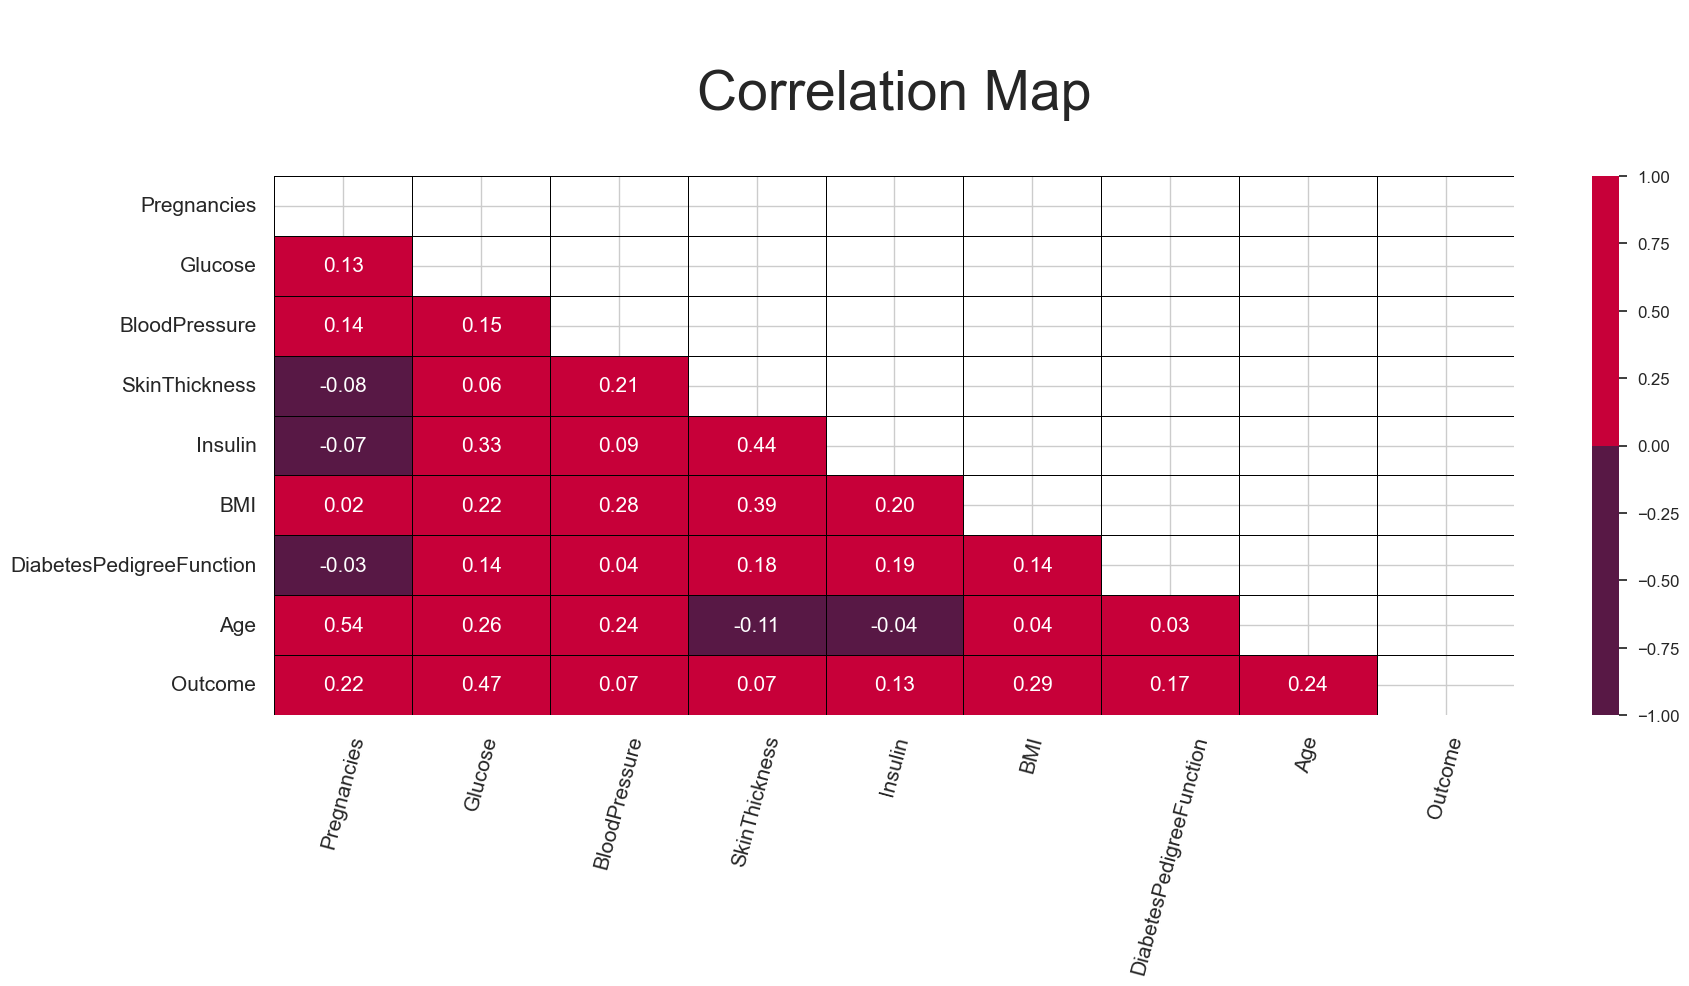

In [12]:
def corr_map(df, width=20, height=7):
    mtx = np.triu(df.corr())
    f, ax = plt.subplots(figsize=(width, height))
    sns.heatmap(df.corr(),
                annot=True,
                fmt=".2f",
                ax=ax,
                vmin=-1,
                vmax=1,
                cmap=constraints,
                mask=mtx,
                linewidth=0.4,
                linecolor="black",
                annot_kws={"size": 15})
    plt.yticks(rotation=0, size=15)
    plt.xticks(rotation=75, size=15)
    plt.title('\nCorrelation Map\n', size=40)
    plt.show()


corr_map(df)

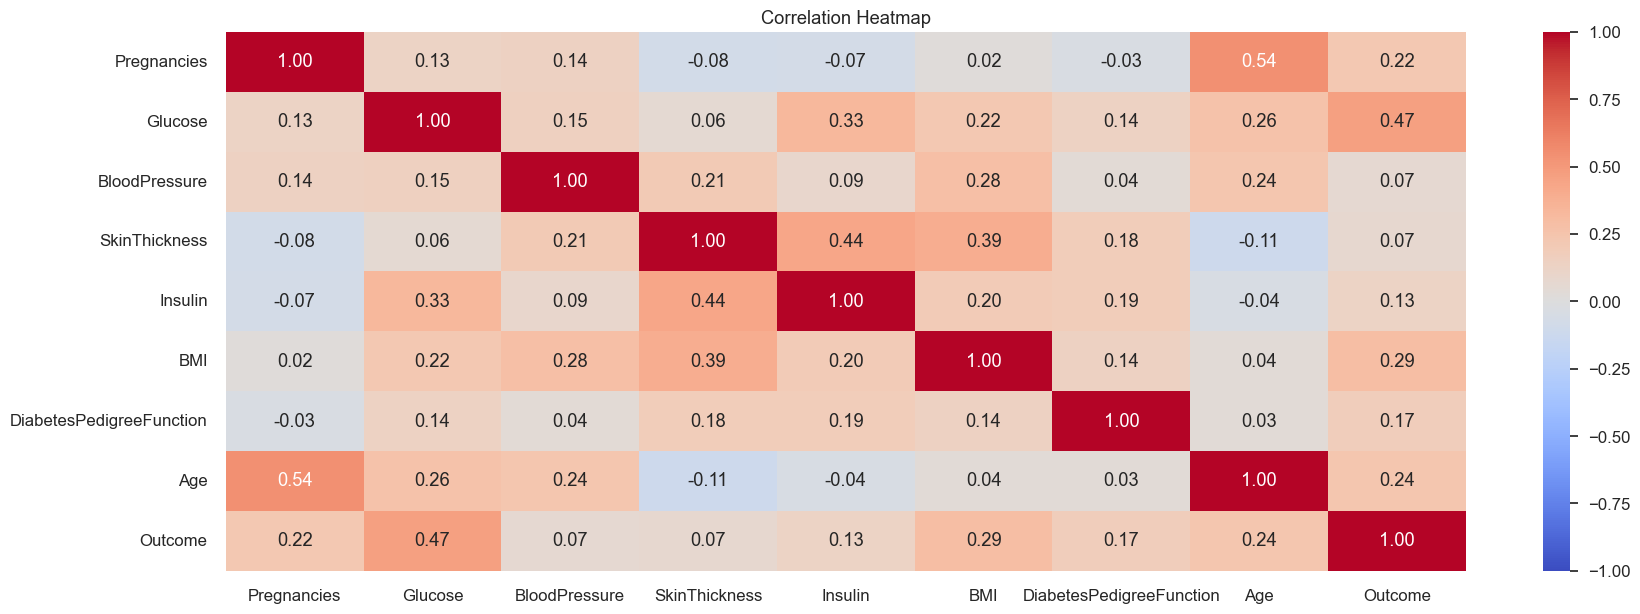

In [13]:
def plot_correlation_heatmap(dataframe):
    correlation_matrix = dataframe.corr()

    plt.figure(figsize=(20, 7))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
    plt.title("Correlation Heatmap")
    plt.show()


plot_correlation_heatmap(df)


In [14]:
cor_matrix = df.corr().abs()
upper_triangle_matrix = cor_matrix.where(
    np.triu(np.ones(cor_matrix.shape), k=1).astype(bool))
drop_list = [col for col in upper_triangle_matrix.columns if any(
    upper_triangle_matrix[col] > 0.90)]


def high_correlated_cols(dataframe, plot=False, corr_th=0.90):
    corr = dataframe.corr()
    cor_matrix = corr.abs()
    upper_triangle_matrix = cor_matrix.where(
        np.triu(np.ones(cor_matrix.shape), k=1).astype(bool))
    drop_list = [col for col in upper_triangle_matrix.columns if any(
        upper_triangle_matrix[col] > corr_th)]
    if plot:

        sns.set(rc={'figure.figsize': (15, 15)})
        sns.heatmap(corr, cmap="RdBu", annot=True, fmt=".2f", vmin=-1, vmax=1)
        plt.show()
    return drop_list


high_correlated_cols(df.drop(drop_list, axis=1), plot=False)

[]

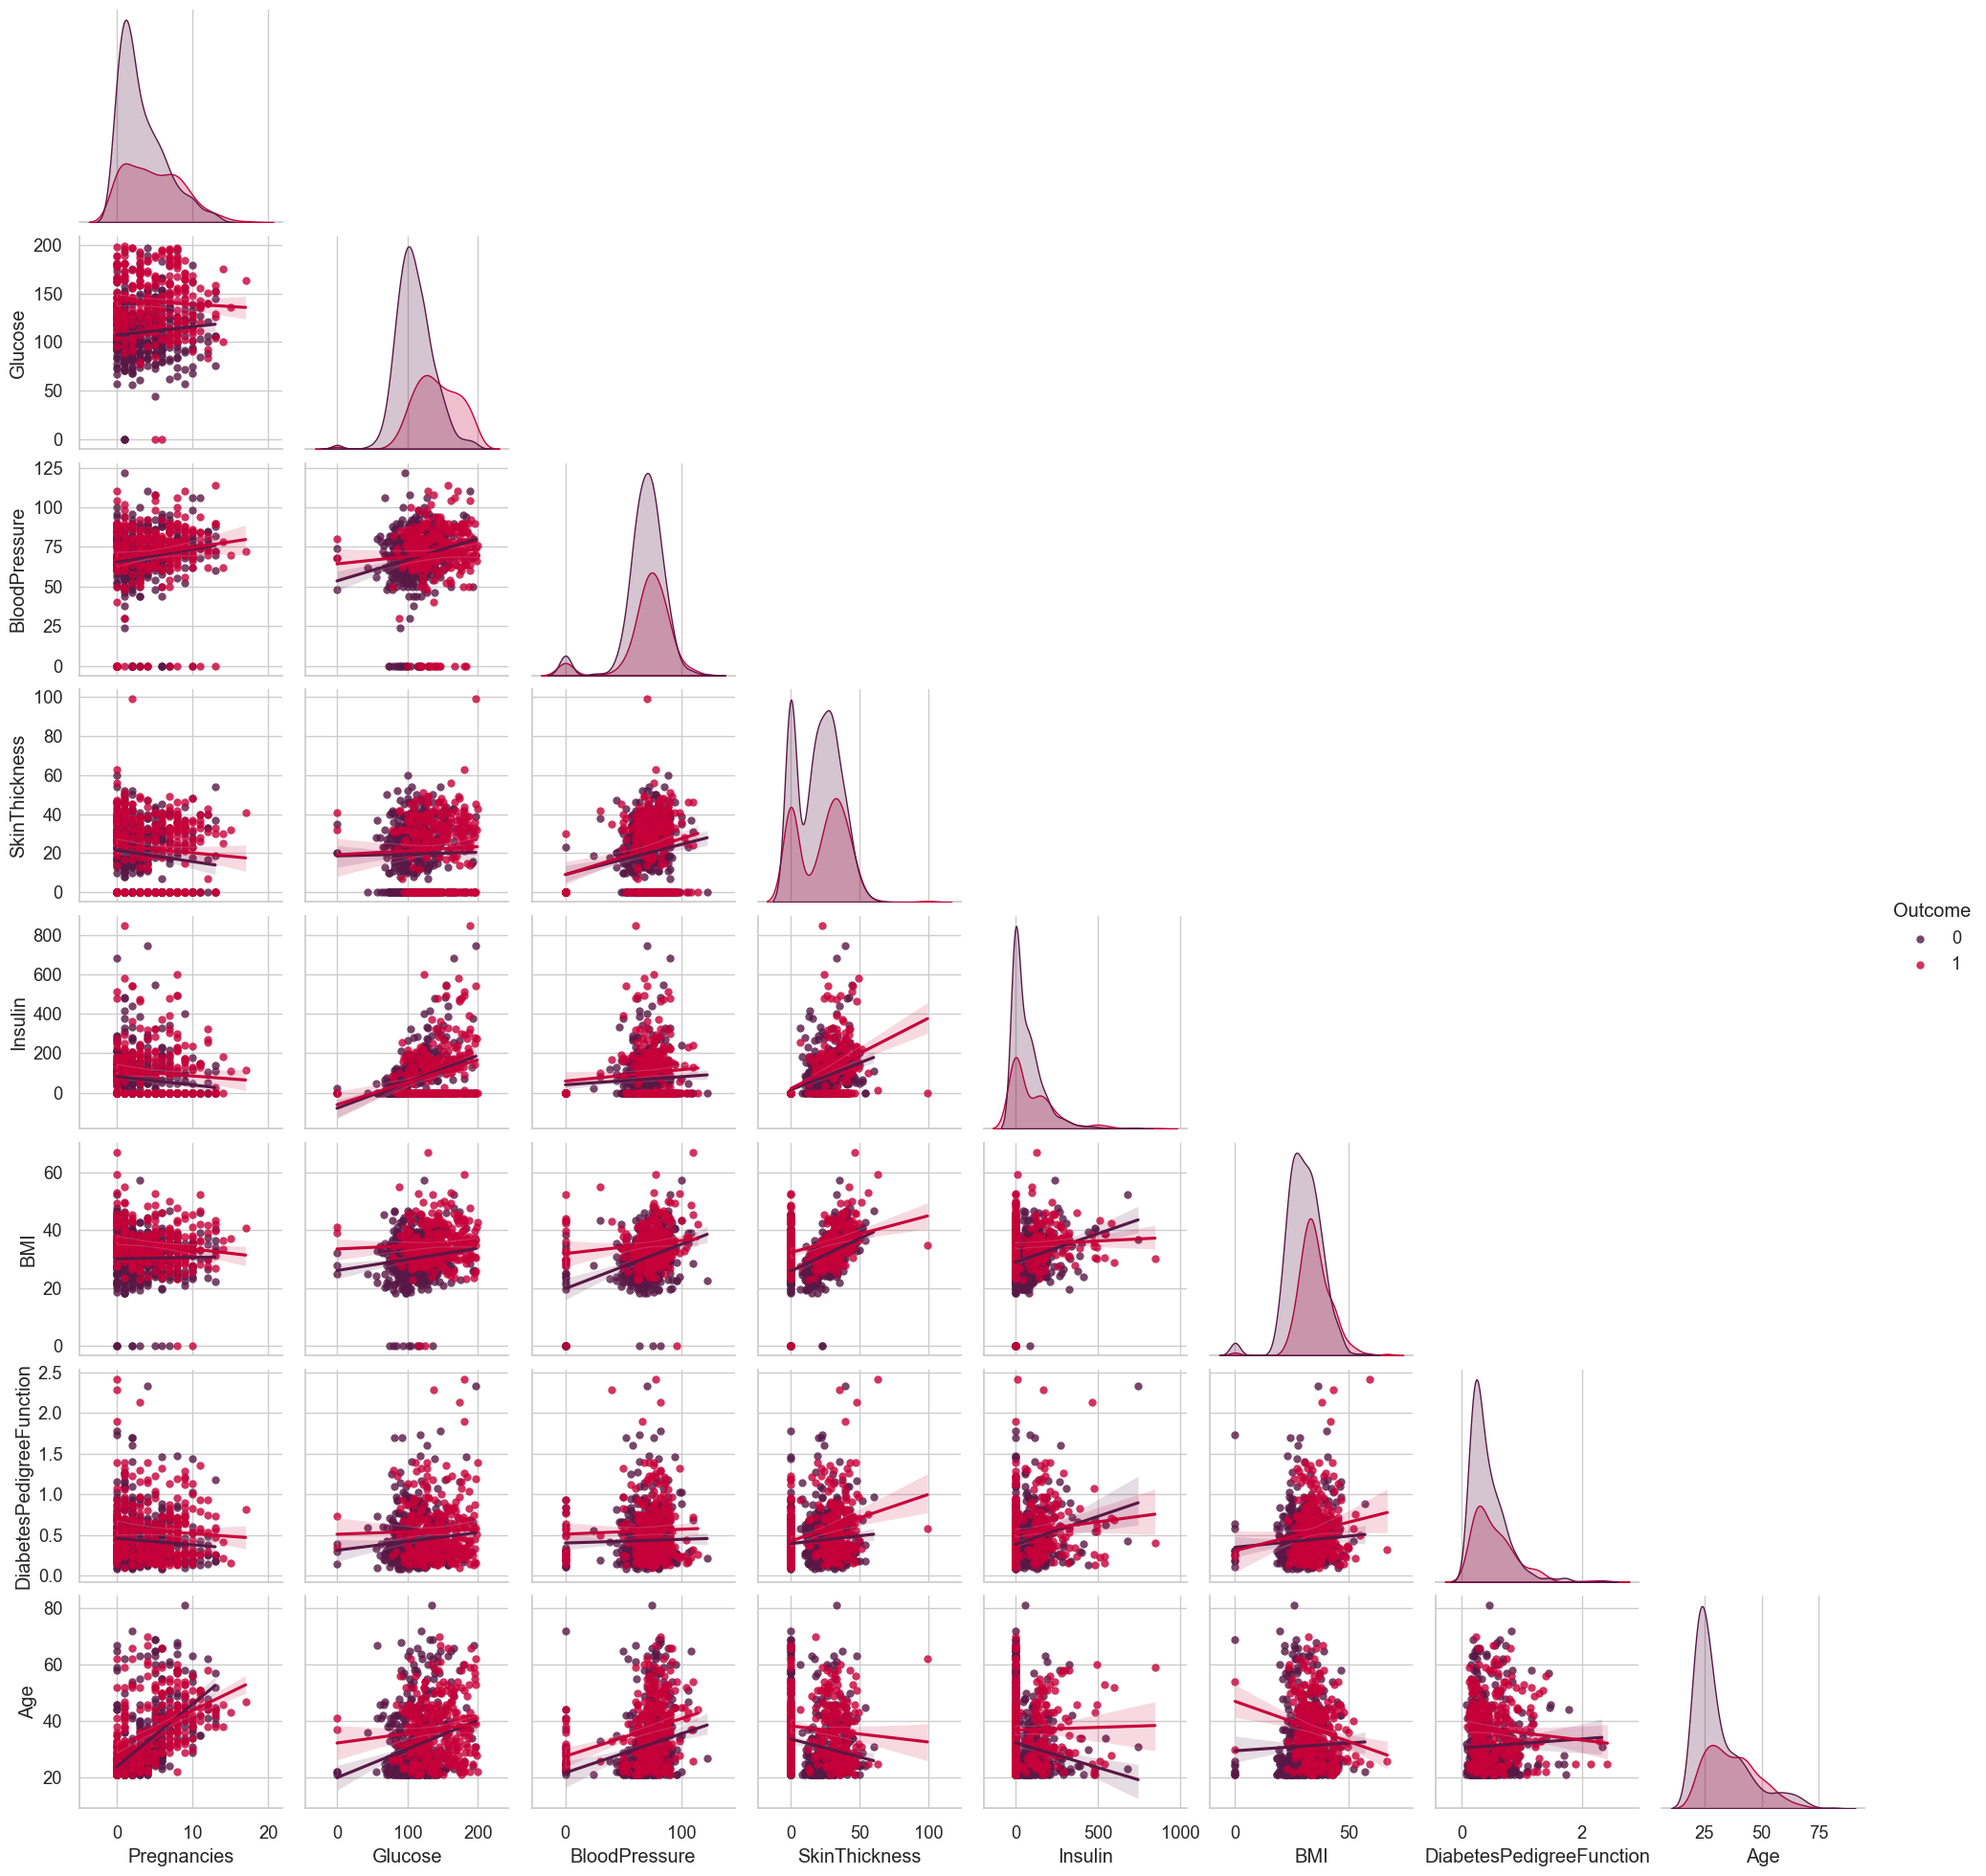

In [15]:
sns.set(font_scale=1.2,
        style="whitegrid",
        palette=constraints,
        font="sans-serif")
sns.pairplot(df,
             hue='Outcome',
             corner=True,
             kind='reg');

In [16]:
def print_zeros(dataframe):
    zero_counts = {}
    total_rows = len(dataframe)

    for col in dataframe.columns:
        if col not in ['Pregnancies', 'Outcome']:
            zeros_in_col = dataframe[col].eq(0).sum()
            zero_counts[col] = zeros_in_col

    if zero_counts:
        result_df = pd.DataFrame.from_dict(zero_counts, orient='index', columns=['Zero_Count'])
        result_df['Percentage'] = (result_df['Zero_Count'] / total_rows) * 100

        return result_df
    
    else:
        return pd.DataFrame()
    
print_zeros(df)

,Zero_Count,Percentage
Glucose,5,0.65104
BloodPressure,35,4.55729
SkinThickness,227,29.55729
Insulin,374,48.69792
BMI,11,1.43229
DiabetesPedigreeFunction,0,0.00000
Age,0,0.00000


In [17]:
# Handling Zeros Values

na_columns = [col for col in df.columns if df[col].min() == 0 and col not in [
    "Pregnancies", "Outcome"]]

for col in na_columns:
    df[col] = np.where(df[col] == 0, np.nan, df[col]) # 0 değerinin anlamlı olmadığı değişkenler için NA ataması

# Feature Engineering

In [18]:
class CorrImputer:
    def __init__(self, target_name, target_values):
        self.target_name = target_name
        self.target_values = target_values
        self.group_medians = {}
    def fit(self, data):
        for col in data.columns:
            if col != self.target_name:
                self.group_medians[col] = data.groupby(self.target_values)[col].transform('median')
    def transform(self, data):
        for col in data.columns:
            if col != self.target_name and col in self.group_medians:
                data[col].fillna(self.group_medians[col], inplace=True)

        return data
    def fit_transform(self, data):
        self.fit(data)
        return self.transform(data)

In [19]:
class CFG:
    outlier_clipper = True
    outlier_remover = False
    outlier_replacer = False
    
    one_hot_encoder = True
    label_encoder = True
    ordinal_encoder = False
    
    min_max_scaler = False
    robust_scaler = False
    standard_scaler = False

# Outliers

In [20]:
def outlier_thresholds(dataframe, col, low_quantile=0.07, up_quantile=0.93):

    quantile_one = dataframe[col].quantile(low_quantile)
    quantile_three = dataframe[col].quantile(up_quantile)

    interquantile_range = quantile_three - quantile_one
    up_limit = quantile_three + 1.5 * interquantile_range
    low_limit = quantile_one - 1.5 * interquantile_range

    return low_limit, up_limit


def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True, len(dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)]);
    else:
        return False


for col in num_cols:
    print(f"{col}, outlier detection is {check_outlier(df, col)}")


Pregnancies, outlier detection is False
Glucose, outlier detection is False
BloodPressure, outlier detection is False
SkinThickness, outlier detection is (True, 1)
Insulin, outlier detection is (True, 1)
BMI, outlier detection is False
DiabetesPedigreeFunction, outlier detection is (True, 3)
Age, outlier detection is False


In [21]:
class DataProcessor:
    def __init__(self, cfg):
        self.cfg = cfg

    def process_data(self, dataframe):
        if self.cfg.outlier_clipper:
            for col in dataframe.columns:
                if dataframe[col].dtypes not in ['object', 'category']:
                    q1_val = dataframe[col].quantile(0.07)
                    q3_val = dataframe[col].quantile(0.93)
                    dataframe.loc[:, col] = dataframe[col].clip(
                        lower=q1_val, upper=q3_val)

        if self.cfg.outlier_remover:
            for col in dataframe.columns:
                if dataframe[col].dtypes not in ['object', 'category']:
                    q1_val = dataframe[col].quantile(0.07)
                    q3_val = dataframe[col].quantile(0.93)
                    dataframe = dataframe.loc[(dataframe[col] >= q1_val) & (
                        processed_data[col] <= q3_val)]

        if self.cfg.outlier_replacer:
            for col in dataframe.columns:
                if dataframe[col].dtypes not in ['object', 'category']:
                    median_val = dataframe[col].median()
                    dataframe[col] = dataframe[col].where(
                        (dataframe[col] >= q1_val) & (dataframe[col] <= q3_val), median_val)

        return dataframe


data_processor = DataProcessor(CFG())
df = data_processor.process_data(df)

# Missing Values

In [22]:
def check_missing_value(dataframe, na_name=False):
    na_columns = [
        col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() /
             dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)],
                           axis=1, keys=['n_miss', 'ratio'])
    print(missing_df)

    if na_name:
        return na_columns

check_missing_value(df)

               n_miss    ratio
Insulin           374 48.70000
SkinThickness     227 29.56000
BloodPressure      35  4.56000
BMI                11  1.43000
Glucose             5  0.65000


In [23]:
def missing_vs_target(dataframe, target, na_columns):
    temp_df = dataframe.copy()

    for col in na_columns:
        temp_df[col + '_NA_FLAG'] = np.where(temp_df[col].isnull(), 1, 0)

    na_flags = temp_df.loc[:, temp_df.columns.str.contains("_NA_")].columns

    for col in na_flags:
        display(pd.DataFrame({"TARGET_MEAN": temp_df.groupby(col)[target].mean(),
                              "Count": temp_df.groupby(col)[target].count()}))


na_columns = check_missing_value(df, na_name=True)
missing_vs_target(df, 'Outcome', na_columns)

               n_miss    ratio
Insulin           374 48.70000
SkinThickness     227 29.56000
BloodPressure      35  4.56000
BMI                11  1.43000
Glucose             5  0.65000


,TARGET_MEAN,Count
Glucose_NA_FLAG,,
0,0.34862,763
1,0.40000,5


,TARGET_MEAN,Count
BloodPressure_NA_FLAG,,
0,0.34379,733
1,0.45714,35


,TARGET_MEAN,Count
SkinThickness_NA_FLAG,,
0,0.33272,541
1,0.38767,227


,TARGET_MEAN,Count
Insulin_NA_FLAG,,
0,0.32995,394
1,0.36898,374


,TARGET_MEAN,Count
BMI_NA_FLAG,,
0,0.35139,757
1,0.18182,11


In [25]:
def best_imputation_method(data, target_column):
    missing_values = data.isnull().sum()
    missing_percent = (missing_values / len(data)) * 100
    missing_columns = missing_values[missing_values > 0].index.tolist()
    numeric_columns = data.select_dtypes(include=[np.number]).columns.tolist()

    imputation_methods = {
        "Mean": SimpleImputer(strategy="mean"),
        "Median": SimpleImputer(strategy="median"),
        "Most Frequent": SimpleImputer(strategy="most_frequent"),
        "KNN": KNNImputer(n_neighbors=5),
        "Iterative": IterativeImputer(max_iter=10, random_state=0),
        'CorrImputer': CorrImputer('Outcome', df['Outcome'])
    }

    results = {}
    for column in missing_columns:
        if column in numeric_columns:
            for method_name, method in imputation_methods.items():
                missing_data = data[data[column].isnull()]

                imputed_data = data.copy()
                imputed_data[column] = method.fit_transform(imputed_data[[column]])

                performance_metric = abs(imputed_data[target_column].corr(imputed_data[column]))

                results[f"{column} - {method_name}"] = performance_metric

    variables = set([col.split(" - ")[0] for col in results.keys()])
    best_methods = {}
    for variable in variables:
        variable_results = {key: value for key, value in results.items() if key.startswith(variable)}

        best_method = max(variable_results, key=variable_results.get)
        best_methods[variable] = best_method.split(" - ")[1]
    return best_methods, imputation_methods

def impute_nulls(data, target_column):
    # data = data.copy()
    best_methods, imputation_methods = best_imputation_method(data, target_column)
    print(best_methods)
    for column, method in best_methods.items():
        data[column] = imputation_methods[method].fit_transform(data[[column]])

target_column = "Outcome"
impute_nulls(df, target_column)


{'BMI': 'CorrImputer', 'Glucose': 'CorrImputer', 'SkinThickness': 'CorrImputer', 'BloodPressure': 'CorrImputer', 'Insulin': 'CorrImputer'}


In [ ]:
# from miceforest import ImputationKernel

# df = ImputationKernel(
#     data=df[num_cols],
#     save_all_iterations=True,
#     random_state=2023
# )

# df.mice(2)
# df = df.complete_data()

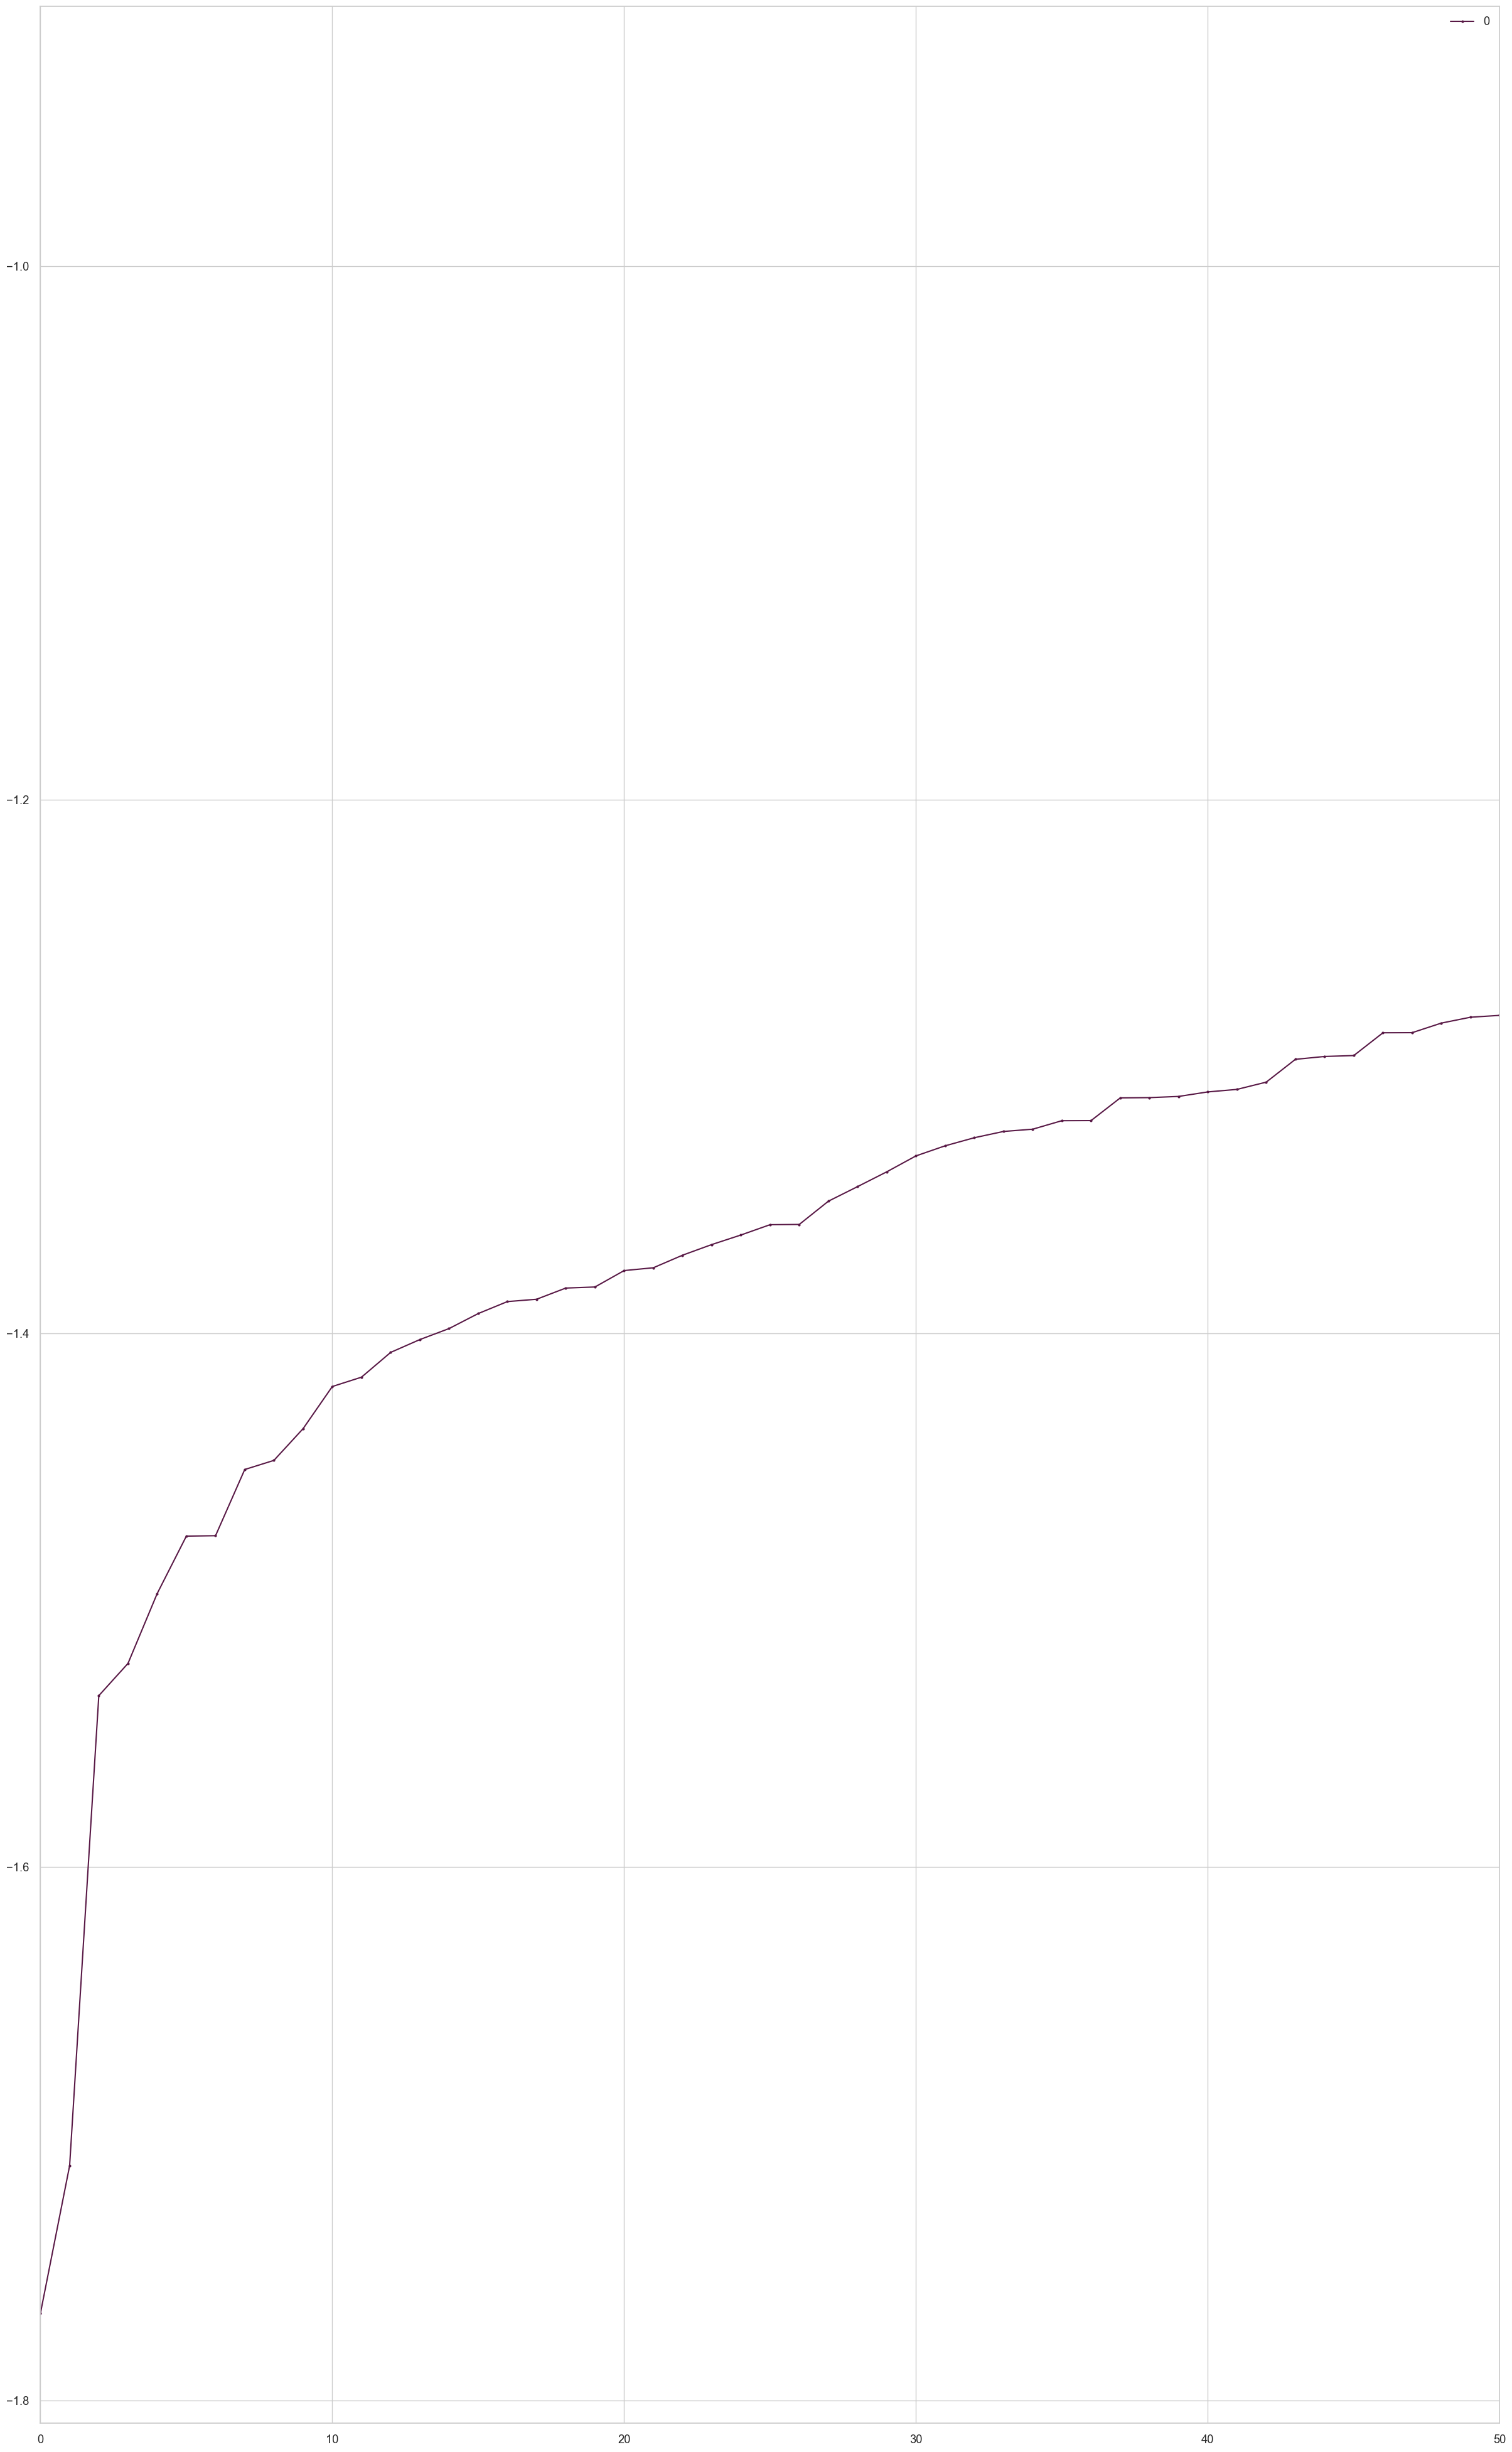

In [74]:
clf = LocalOutlierFactor(n_neighbors=20)
clf.fit_predict(df)
df_scores = clf.negative_outlier_factor_
scores = pd.DataFrame(np.sort(df_scores))
scores.plot(stacked=True, xlim=[0, 50], style='.-')
plt.show()

In [75]:
th = np.sort(df_scores)[5]
df[df_scores < th].index
df[df_scores < th].drop(axis=0, labels=df[df_scores < th].index, inplace=True)

# New Variables

In [76]:
def extract_features(dataframe):
    dataframe['BMI_CAT'] = pd.cut(x=dataframe['BMI'],
                                  bins=[0, 18.5, 24.9, 29.9,
                                        34.9, 39.9, np.inf],
                                  labels=["Underweight", "Healthy", "Overweight", "Obese Class I", "Obese Class II", "Obese Class III"])

    dataframe['Age_CAT'] = pd.cut(x=dataframe['Age'],
                                  bins=[0, 18, 30, 50, np.inf],
                                  labels=["Young", "Adult", "Middle-aged", "Senior"])

    dataframe['Glucose_CAT'] = pd.cut(x=dataframe['Glucose'],
                                      bins=[0, 100, 140, 199, np.inf],
                                      labels=["Low", "Normal", "Pre-Diabetes", "Diabetes"])

    dataframe['Insulin_CAT'] = pd.cut(x=dataframe['Insulin'],
                                      bins=[0, 100, 140, 199, np.inf],
                                      labels=["Low", "Normal", "Pre-High", "High"])

    dataframe['BloodPressure_CAT'] = pd.cut(x=dataframe['BloodPressure'],
                                            bins=[0, 80, 90, 120, np.inf],
                                            labels=["Low", "Normal", "Pre-High", "High"])

    dataframe['Pregnancy_Cat'] = pd.cut(x=dataframe['Pregnancies'],
                                        bins=[0, 1, 4, 10, np.inf],
                                        labels=["Childless", "One-Three",
                                                "Four-Nine", "Over-Ten"],
                                        right=False)


extract_features(df)

In [77]:
df["OBESE"] = np.where(df.BMI >= 30, 1, 0)
df["Is_Have_Child"] = np.where(df.Pregnancies > 0, 1, 0)

df["hypoglycaemia"] = np.where(df.Glucose < 70, 1, 0)
df["Glucose_Cat"] = np.where(df.Glucose < 140, 0, 1)  # 0 => No Risk , 1 => 1 At Risk

In [78]:
df['Glucose_BMI'] = df['Glucose'] * df['BMI']
df['Age_DiabetesPedigreeFunction'] = df['Age'] * df['DiabetesPedigreeFunction']
df['Pregnancies_Per_Age'] = df['Pregnancies'] / df['Age']
df['Glucose_Minus_Insulin'] = df['Glucose'] - df['Insulin']
df['GIR'] = df['Glucose'] / df['Insulin']
df['BMI_DiabetesPedigree'] = df['BMI'] * df['DiabetesPedigreeFunction']
df['Age_Insulin'] = df['Age'] * df['Insulin']
df['Glucose_BMI_Difference'] = df['Glucose'] - df['BMI']
df["glucose_per_bmi"] = df["Glucose"] / df["BMI"]
df["insulin_per_age"] = df["Insulin"] / df["Age"]


In [79]:
# def glucose_level(glucose):
#     if 16 <= glucose <= 140:
#         return "Normal"
#     elif 140 < glucose <= 200:
#         return "Prediabetes"
#     else:
#         return "Diabetes"


# df["Glucose_Level"] = df["Glucose"].apply(glucose_level)
############################################################

# def glucose_level(dataframe, col_name="Glucose"):
#     if 16 <= dataframe[col_name] <= 140:
#         return "Normal"
#     elif 140 < dataframe[col_name] <= 200:
#         return "Prediabetes"
#     else:
#         return "Diabetes"
# 
# 
# df["Glucose_Level"] = df.apply(glucose_level, axis=1)


In [80]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 768 	 Variables: 29
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
cat_cols size: 11
cat_cols: ['Outcome', 'BMI_CAT', 'Age_CAT', 'Glucose_CAT', 'Insulin_CAT', 'BloodPressure_CAT', 'Pregnancy_Cat', 'OBESE', 'Is_Have_Child', 'hypoglycaemia', 'Glucose_Cat']
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
num_cols size: 18
num_cols: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Glucose_BMI', 'Age_DiabetesPedigreeFunction', 'Pregnancies_Per_Age', 'Glucose_Minus_Insulin', 'GIR', 'BMI_DiabetesPedigree', 'Age_Insulin', 'Glucose_BMI_Difference', 'glucose_per_bmi', 'insulin_per_age']
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
cat_but_car size: 0
cat_but_car: []
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

In [81]:
# Categorical Features Summary

def summary_cat_features(dataframe, column_name, label):
    data = go.Bar(x=dataframe.groupby(column_name).agg({label: 'mean'}).reset_index()[column_name],
                  y=dataframe.groupby(column_name).agg({label: 'mean'}).reset_index()[label],
                  text=round(dataframe.groupby(column_name).agg({label: 'mean'}).reset_index()[label], 3),
                  textposition='auto',
                  marker=dict(color=cat_feat_constraints, line_color='white', line_width=1.5))

    layt = go.Layout(title={'text': f'Average {label} by {column_name} Categories', 'y': 0.9, 'x': 0.2,
                            'xanchor': 'center', 'yanchor': 'top'},
                     xaxis=dict(title=column_name),
                     yaxis=dict(title=label),
                     template='plotly_white')

    fig = go.Figure(data=data, layout=layt)
    iplot(fig)


for i in [col for col in cat_cols if col != "Outcome"]:
    categorical_variable_summary(df, i)
    summary_cat_features(df, i, 'Outcome')

# Encoding Processing Control

In [82]:
class DataProcessorEncode:
    def __init__(self, cfg):
        self.cfg = cfg

    def encode_data(self, dataframe):
        if self.cfg.one_hot_encoder:
            # object_cols = dataframe.select_dtypes(include=['object', 'category']).columns
            object_cols = [col for col in dataframe.columns if 10 >= dataframe[col].nunique() > 2]

            if len(object_cols) > 0:
                dataframe = pd.get_dummies(dataframe, columns=object_cols, drop_first=True, dtype=int)
                print("One-hot encoding applied.")
            else:
                print("Warning: No object or category columns found. One-hot encoding was not applied.")


        if self.cfg.label_encoder:
            label_encoder = LabelEncoder()
            object_cols = [col for col in dataframe.columns if dataframe[col].dtypes in ['object', 'category'] and dataframe[col].nunique() == 2]
            # object_cols = dataframe.select_dtypes(include=['object', 'category']).columns
            if len(object_cols) > 0:
                for col in object_cols:
                    dataframe[col] = label_encoder.fit_transform(dataframe[col])
                    print("Label encoding applied.")
            else:
                print("Warning: No object or category columns found. Label encoding was not applied.")
                
        if self.cfg.ordinal_encoder:
            ordinal_encoder = {}  # Boş bir sözlük oluşturuyoruz.
            object_cols = dataframe.select_dtypes(include=['object', 'category']).columns
            if len(object_cols) > 0:
                for col in object_cols:
                    unique_values = sorted(dataframe[col].unique())
                    ordinal_encoder[col] = {value: index for index, value in enumerate(unique_values)}
                    dataframe[col] = dataframe[col].map(ordinal_encoder[col])
                    print("Ordinal encoding applied.")
            else:
                print("Warning: No object or category columns found. Ordinal encoding was not applied.")


        return dataframe

data_processor_encode = DataProcessorEncode(CFG())
df = data_processor_encode.encode_data(df)

One-hot encoding applied.
Label encoding applied.


# Scaling Processing Control

In [83]:
def select_best_scaler(data, scaler_list, target_variable):
    results = {}

    for scaler in scaler_list:
        transformed_data = scaler.fit_transform(data)
        sample_model = KNeighborsClassifier()
        sample_model.fit(transformed_data, target_variable)
        accuracy = sample_model.score(transformed_data, target_variable)
        results[scaler] = accuracy

    best_scaler_name = max(results, key=results.get)

    return best_scaler_name

scaler_list = [StandardScaler(), MinMaxScaler(), RobustScaler()]
best_scaler = select_best_scaler(df, scaler_list, df['Outcome'])
print("Best scaler:", best_scaler)

# num_cols = df.select_dtypes(include=[int, float]).columns
# df[num_cols] = best_scaler.fit_transform(df[num_cols])
# print(f"{best_scaler} applied.")

if str(best_scaler) == "StandardScaler()":
    CFG.standard_scaler = True
elif str(best_scaler) == "MinMaxScaler()":
    CFG.min_max_scaler = True
elif str(best_scaler) == "RobustScaler()":
    CFG.robust_scaler = True    

Best scaler: MinMaxScaler()


In [84]:
class DataProcessorScaled:
    def __init__(self, cfg):
        self.cfg = cfg

    def scaled_data(self, dataframe):
        if self.cfg.min_max_scaler:
            num_cols = dataframe.select_dtypes(include=['int', 'float']).columns
            if len(num_cols) > 0:
                min_max_scaler = MinMaxScaler()
                dataframe[num_cols] = min_max_scaler.fit_transform(dataframe[num_cols])
                print("Min-Max scaling applied.")
            else:
                print("Warning: No numerical columns found. Min-Max scaling was not applied.")

        if self.cfg.standard_scaler:
            num_cols = dataframe.select_dtypes(include=['int', 'float']).columns
            if len(num_cols) > 0:
                standard_scaler = StandardScaler()
                dataframe[num_cols] = standard_scaler.fit_transform(dataframe[num_cols])
                print("Standard scaling applied.")
            else:
                print("Warning: No numerical columns found. Standard scaling was not applied.")

        if self.cfg.robust_scaler:
            num_cols = dataframe.select_dtypes(include=['int', 'float']).columns
            if len(num_cols) > 0:
                robust_scaler = RobustScaler()
                dataframe[num_cols] = robust_scaler.fit_transform(dataframe[num_cols])
                print("Robust scaling applied.")
            else:
                print("Warning: No numerical columns found. Robust scaling was not applied.")

        return dataframe
    
data_processor_scale = DataProcessorScaled(CFG())
df = data_processor_scale.scaled_data(df)

Min-Max scaling applied.


In [ ]:
# def rare_analyser(df, target, cat_cols):
#     for col in cat_cols:
#         print(col, ":", len(df[col].value_counts()))
#         print(pd.DataFrame({
#             "COUNT": df[col].value_counts(),
#             "RATIO": df[col].value_counts() / len(df),
#             "TARGET_MEAN": df.groupby(col)[target].mean()
#         }), end="\n\n")


# def rare_encoder(df, rare_perc):
#     temp_df = df.copy()
#     rare_columns = [col for col in temp_df.columns if temp_df[col].dtype == "O" and
#                     (temp_df[col].value_counts() / len(temp_df) < rare_perc).any(axis=None)]
#     # bu şarta uyan kolon var mı
#     for var in rare_columns:
#         tmp = temp_df[var].value_counts() / len(temp_df)
#         rare_labels = tmp[tmp < rare_perc].index
#         temp_df[var] = np.where(temp_df[var].isin(
#             rare_labels), "Rare", temp_df[var])
#     return temp_df


# new_df = rare_encoder(df, 0.01)
# rare_analyser(new_df, "Outcome", cat_cols)

# Train - Test Split

In [85]:
y = df['Outcome']
X = df.drop(['Outcome'], axis=1)
random_state = 135

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    # random_state=random_state,
                                                    random_state=random_state,
                                                    stratify=y,
                                                    test_size=0.2,
                                                    shuffle=True)

print(f"The shape of X_train: {colored(X_train.shape,'red')}")
print(f"The shape of X_test: {colored(X_test.shape,'red')}")
print(f"The shape of y_train: {colored(y_train.shape,'red')}")
print(f"The shape of y_test: {colored(y_test.shape,'red')}")

The shape of X_train: (614, 40)
The shape of X_test: (154, 40)
The shape of y_train: (614,)
The shape of y_test: (154,)


In [86]:
metric_res = []
models = []

# models.append(("LGBMClassifier", LGBMClassifier()))
# models.append(('XGBClassifier', XGBClassifier()))
# models.append(('CatBoostClassifier', CatBoostClassifier(verbose=False, )))
# models.append(('GradientBoostingClassifier', GradientBoostingClassifier()))
# models.append(('AdaBoostClassifier', AdaBoostClassifier()))
# models.append(('RandomForestClassifier', RandomForestClassifier()))
# models.append(('DecisionTreeClassifier', DecisionTreeClassifier()))
# models.append(('LogisticRegression', LogisticRegression()))
# models.append(('MLPClassifier', MLPClassifier()))
# models.append(('KNeighborsClassifier', KNeighborsClassifier()))

models.append(("LGBMClassifier", LGBMClassifier(random_state = random_state)))
models.append(('XGBClassifier', XGBClassifier(random_state = random_state)))
models.append(('CatBoostClassifier', CatBoostClassifier(verbose=False, random_state = random_state)))
models.append(('GradientBoostingClassifier', GradientBoostingClassifier(random_state = random_state)))
models.append(('AdaBoostClassifier', AdaBoostClassifier(random_state = random_state)))
models.append(('RandomForestClassifier', RandomForestClassifier(random_state = random_state)))
models.append(('DecisionTreeClassifier', DecisionTreeClassifier(random_state = random_state)))
models.append(('LogisticRegression', LogisticRegression(random_state = random_state)))
models.append(('MLPClassifier', MLPClassifier(random_state = random_state)))
models.append(('KNeighborsClassifier', KNeighborsClassifier()))

In [87]:
def clc_ml(model):

    y_pred = model.fit(X_train, y_train).predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    score = model.score(X_test, y_test)

    # kfold = KFold(n_splits=10, shuffle=True)
    kfold = KFold(n_splits=10, shuffle=True, random_state=random_state)
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring="accuracy")
    cv_mean = cv_results.mean()

    mt_dataframe = pd.DataFrame({'Scores': [accuracy, score, cv_mean, f1, precision, recall, roc_auc],
                                 'Metrics': ['Accuracy',
                                             'Score',
                                             'Cross-Validation Mean',
                                             'F1-Score',
                                             'Precision',
                                             'Recall',
                                             'ROC-AUC',
                                             ]})
    model_results = pd.DataFrame({
        'Model': [name],
        'Accuracy': [accuracy],
        'Score': [score],
        'Cross-Validation Mean': [cv_mean],
        'F1-Score': [f1],
        'Precision': [precision],
        'Recall': [recall],
        'ROC-AUC': [roc_auc],
    })
    metric_res.append(model_results)

    fig = make_subplots(rows=1, cols=2)
    fig.add_trace(go.Bar(x=[round(i, 5) for i in mt_dataframe['Scores']],
                         y=mt_dataframe['Metrics'],
                         text=[round(i, 5) for i in mt_dataframe['Scores']],
                         orientation='h',
                         textposition='inside',
                         name='Scores',
                         marker=dict(color=metric_constraints,
                                     line_color='white',
                                     line_width=1.5)),
                  row=1, col=1)

    import inflect
    # Confusion matrix'in ısı haritasını çizdirme
    cm = confusion_matrix(y_test, y_pred)
    heatmap = go.Heatmap(
        z=cm,
        x=['0', '1'],
        y=['0', '1'],
        colorscale='Blues',
        texttemplate="%{z}"
    )
    fig.add_trace(heatmap, row=1, col=2)

    # İnflect motoru oluşturma
    p = inflect.engine()

    # Örnek veri çerçevesi
    df = px.data.medals_wide(indexed=True)

    # Veriyi izleme eğrisine çevirme ve çizdirme
    heatmap_trace = px.imshow(df, text_auto=True)
    for key in heatmap_trace:
        if 'heatmap' in key:
            fig.add_trace(heatmap_trace[key], row=1, col=2)

    fig.update_layout(title={'text': model.__class__.__name__,
                             'y': 0.9,
                             'x': 0.5,
                             'xanchor': 'center',
                             'yanchor': 'top'},
                      template='plotly_white')
    fig.update_xaxes(range=[0, 1], row=1, col=1)

    iplot(fig)


for name, model in models:
    clc_ml(model)

In [88]:
final_results = pd.concat(metric_res, ignore_index=True)
final_results.sort_values(by='Accuracy', ascending=False)

,Model,Accuracy,Score,Cross-Validation Mean,F1-Score,Precision,Recall,ROC-AUC
4,AdaBoostClassifier,0.89610,0.89610,0.86063,0.84000,0.91304,0.77778,0.91528
2,CatBoostClassifier,0.88961,0.88961,0.87620,0.83495,0.87755,0.79630,0.94130
0,LGBMClassifier,0.88312,0.88312,0.88669,0.82353,0.87500,0.77778,0.95667
3,GradientBoostingClassifier,0.88312,0.88312,0.88401,0.82692,0.86000,0.79630,0.94481
8,MLPClassifier,0.88312,0.88312,0.85405,0.82692,0.86000,0.79630,0.92907
1,XGBClassifier,0.87662,0.87662,0.88664,0.81188,0.87234,0.75926,0.93981
5,RandomForestClassifier,0.87013,0.87013,0.86579,0.80769,0.84000,0.77778,0.93630
7,LogisticRegression,0.87013,0.87013,0.86188,0.80392,0.85417,0.75926,0.92037
9,KNeighborsClassifier,0.85714,0.85714,0.82937,0.78846,0.82000,0.75926,0.87685
6,DecisionTreeClassifier,0.84416,0.84416,0.82543,0.78571,0.75862,0.81481,0.83741


In [89]:
final_model = eval(final_results.sort_values(by='Accuracy', ascending=False).iloc[0, 0] + "(verbose=False)").fit(X_train, y_train) if final_results.sort_values(
    by='Accuracy', ascending=False).iloc[0, 0] == "CatBoostClassifier" else eval(final_results.sort_values(by='Accuracy', ascending=False).iloc[0, 0] + "()").fit(X_train, y_train)

In [ ]:
from sklearn.inspection import permutation_importance

def plot_importance(model, X_train, y_train, features, num=None, save=False):
    if type(model).__name__ in ['MLPClassifier', "KNeighborsClassifier"]:
        result = permutation_importance(model, X_train, y_train, n_repeats=10, random_state=0)
        feature_importances = result.importances_mean
    else:
        feature_importances = model.feature_importances_

    feature_imp = pd.DataFrame({'Value': feature_importances, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                    ascending=False)[:num])

    
    # viz = FeatureImportances(model).fit(X_train, y_train)
    plt.title(f'Features using model {type(model).__name__}')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')
    
plot_importance(final_model, X_train, y_train, X)


In [ ]:
y_pred_prob = final_model.predict_proba(X_test)[:,1]
fig, ax = plt.subplots(figsize = (6,6))
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr,tpr)
ax.plot(fpr,tpr, label = " area = {:0.2f}".format(roc_auc))
ax.plot([0,1], [0,1], 'r', linestyle = "--", lw = 2)
ax.set_xlabel("False Positive Rate", fontsize = 10)
ax.set_ylabel("True Positive Rate", fontsize = 10)
ax.set_title("ROC Curve", fontsize = 18)
ax.legend(loc = 'best')

close_default = np.argmin(np.abs(thresholds_roc - 0.5))
ax.plot(fpr[close_default], tpr[close_default], 'o', markersize = 8)
plt.tight_layout()

# Model Tuning

In [90]:
def objective(trial):
    param = {
        "iterations": trial.suggest_int("iterations", 100, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 300),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
    }

    model = CatBoostClassifier(
        **param, random_state=random_state, verbose=False).fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred)


optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction="maximize",
                            sampler=optuna.samplers.TPESampler(),)
study.optimize(objective, n_trials=100, n_jobs=-1)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

In [99]:
# finalcat_model = CatBoostClassifier(**trial.params, random_state=random_state).fit(X_train, y_train)
finalcat_model = CatBoostClassifier(**study.best_params, random_state=random_state, verbose=False).fit(X_train, y_train)

y_pred = finalcat_model.predict(X_test)

Accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, finalcat_model.predict_proba(X_test)[:, 1])
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
score = finalcat_model.score(X_test, y_test)
kfold = KFold(n_splits=10, shuffle=True, random_state=random_state)
cv_results = cross_val_score(finalcat_model, X, y, cv=kfold, scoring="accuracy")
cv_mean = cv_results.mean()


results = pd.DataFrame({
        'Accuracy': [Accuracy],
        'Score': [score],
        'Cross-Validation Mean': [cv_mean],
        'F1-Score': [f1],
        'Precision': [precision],
        'Recall': [recall],
        'ROC-AUC': [roc_auc],
    })
results


,Accuracy,Score,Cross-Validation Mean,F1-Score,Precision,Recall,ROC-AUC
0,0.87013,0.87013,0.88271,0.80392,0.85417,0.75926,0.94037


In [94]:
def objective(trial):
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 1.0, log=True)
    }

    model = AdaBoostClassifier(
        **param, random_state=random_state).fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred)


optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction="maximize",
                            sampler=optuna.samplers.TPESampler(),)
study.optimize(objective, n_trials=100, n_jobs=-1)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  100
Best trial:
  Value:  0.8961038961038961
  Params: 
    n_estimators: 520
    learning_rate: 0.027570878441182816


In [101]:
finalada_model = AdaBoostClassifier(**study.best_params, random_state=random_state).fit(X_train, y_train)

y_pred = finalada_model.predict(X_test)

Accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, finalada_model.predict_proba(X_test)[:, 1])
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
score = finalada_model.score(X_test, y_test)
kfold = KFold(n_splits=10, shuffle=True, random_state=random_state)
cv_results = cross_val_score(finalada_model, X, y, cv=kfold, scoring="accuracy")
cv_mean = cv_results.mean()


results = pd.DataFrame({
        'Accuracy': [Accuracy],
        'Score': [score],
        'Cross-Validation Mean': [cv_mean],
        'F1-Score': [f1],
        'Precision': [precision],
        'Recall': [recall],
        'ROC-AUC': [roc_auc],
    })
results

,Accuracy,Score,Cross-Validation Mean,F1-Score,Precision,Recall,ROC-AUC
0,0.89610,0.89610,0.87235,0.84615,0.88000,0.81481,0.93620


# Saving and Loading Model

In [112]:
joblib.dump(final_model, 'diabets_model.pkl')
# cart_model_from_disc = joblib.load('diabets_model.pkl')

['diabets_model.pkl']